## Import
Nous utiliserons une stack de Data Science habituelle : `numpy`, `pandas`, `sklearn`, `matplotlib`.

In [1]:
# manipulation des données
import numpy as np
import pandas as pd

# matplotlib et seaborn pour les représentations graphiques
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# sklearn preprocessing pour le traiter les variables catégorielles
from sklearn.preprocessing import LabelEncoder

# Gestion du système de fichiers
import os
from os import listdir

# Suppression des alertes
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('../Data/3.normalized_dataset_image.csv')
path = '../Data/Flipkart/Images/'
list_photos = [file for file in listdir(path)]
data

,image_path,product_category_tree,label
0,aa68675f50a0551b8dadb954017a50a1.jpg,Kitchen & Dining,5
1,037c2402fee39fbc80433935711d1383.jpg,Home Furnishing,4
2,42643c1c9403f67921a18654bcf45ead.jpg,Baby Care,0
3,53f4bc7d7321f5c41de6b86e41f13e80.jpg,Home Decor & Festive Needs,3
4,b144a363c107c7bdd91f32d6e28ba6f2.jpg,Watches,6
...,...,...,...
1045,4e5ebfc871992e7e22365c0c036a1b89.jpg,Baby Care,0
1046,82fbc93cd45ab747e7e606f2c52c7335.jpg,Home Decor & Festive Needs,3
1047,216c6c3527984be3d7ad9023d5cd9bd1.jpg,Home Decor & Festive Needs,3
1048,f54d0c5cbd8e2270742293edf9075cb1.jpg,Home Furnishing,4


[ WARN:0@0.056] global shadow_sift.hpp:15 SIFT_create DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736


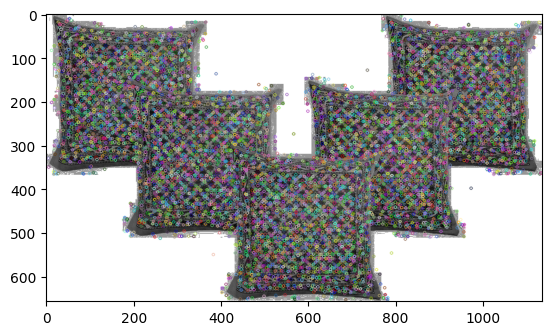

Descripteurs :  (11002, 128)

[[  0.   0.   2. ...   2.   2.  16.]
 [ 27.   2.   2. ...   0.   4.  33.]
 [139.  44.   5. ...   3.   0.   0.]
 ...
 [ 13.  21.   1. ...   0.   1.   4.]
 [  1.   3.   3. ...   0.   0.   0.]
 [ 29.  27.  11. ...   4.  26.   3.]]


In [3]:
import cv2

sift = cv2.xfeatures2d.SIFT_create()
image = cv2.imread(path+list_photos[1],0) # convert in gray
image = cv2.equalizeHist(image)   # equalize image histogram
kp, des = sift.detectAndCompute(image, None)
img=cv2.drawKeypoints(image,kp,image)
plt.imshow(img)
plt.show()
print("Descripteurs : ", des.shape)
print()
print(des)

In [71]:
# identification of key points and associated descriptors
import time, cv2
sift_keypoints = []
temps1=time.time()
desired_keypoints = 500
sift = cv2.xfeatures2d.SIFT_create(desired_keypoints)

for image_num in range(len(list_photos)) :
    if image_num%100 == 0 : print(image_num)
    image = cv2.imread(path+list_photos[image_num],0) # convert in gray
    # image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    res = cv2.equalizeHist(image)   # equalize image histogram
    kp, des = sift.detectAndCompute(res, None)
    sift_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints, dtype=object)
sift_keypoints_all = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

duration1=time.time()-temps1
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000

Nombre de descripteurs :  (517351, 128)
temps de traitement SIFT descriptor :           589.93 secondes


In [72]:
from sklearn import cluster, metrics

# Determination number of clusters
temps1=time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  719
Création de 719 clusters de descripteurs ...
temps de traitement kmeans :             5.46 secondes


In [73]:
# Creation of histograms (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :             1.75 secondes


In [74]:
from sklearn import manifold, decomposition

print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 719)
Dimensions dataset après réduction PCA :  (1050, 499)


In [80]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["product_category_tree"]
df_tsne['cluster'] = data['label'].copy()
print(df_tsne.shape)

(1050, 4)


In [81]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, random_state=6)
df_tsne['cluster_predict'] = cls.fit_predict(X_tsne)

print(df_tsne.shape)

(1050, 5)


In [82]:
def determine_cluster():
    for i in range(7):
        print(f"Valeurs les plus fréquentes pour le cluster prédit {i}")
        print(df_tsne[df_tsne['cluster_predict'] == i]['cluster'].value_counts())
determine_cluster()

Valeurs les plus fréquentes pour le cluster prédit 0
cluster
2    60
5    33
6    19
0    16
4    14
1    10
3     7
Name: count, dtype: int64
Valeurs les plus fréquentes pour le cluster prédit 1
cluster
3    49
2    32
0    28
5    26
1    21
4    18
6    12
Name: count, dtype: int64
Valeurs les plus fréquentes pour le cluster prédit 2
cluster
6    32
4    26
3    23
0    21
2    20
1    17
5    16
Name: count, dtype: int64
Valeurs les plus fréquentes pour le cluster prédit 3
cluster
3    28
4    23
0    15
1     9
5     7
6     6
2     3
Name: count, dtype: int64
Valeurs les plus fréquentes pour le cluster prédit 4
cluster
5    47
6    38
4    21
3    20
0    19
1    17
2    15
Name: count, dtype: int64
Valeurs les plus fréquentes pour le cluster prédit 5
cluster
1    74
6    38
0    13
4    11
5    11
2    10
3     3
Name: count, dtype: int64
Valeurs les plus fréquentes pour le cluster prédit 6
cluster
0    38
4    37
3    20
5    10
2    10
6     5
1     2
Name: count, dtype: int64

In [83]:
from sklearn import metrics

def conf_mat_transform(y_true,y_pred) :
    corresp = [2, 3, 6, 4, 5, 1, 0]

    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(df_tsne['cluster'], cls.labels_)
conf_mat = metrics.confusion_matrix(df_tsne['cluster'], cls.labels_)
conf_matX = metrics.confusion_matrix(df_tsne['cluster'], cls_labels_transform)
print(conf_mat)
print("--------------------------------")
print(conf_matX)

[[16 28 21 15 19 13 38]
 [10 21 17  9 17 74  2]
 [60 32 20  3 15 10 10]
 [ 7 49 23 28 20  3 20]
 [14 18 26 23 21 11 37]
 [33 26 16  7 47 11 10]
 [19 12 32  6 38 38  5]]
--------------------------------
[[38 13 16 28 15 19 21]
 [ 2 74 10 21  9 17 17]
 [10 10 60 32  3 15 20]
 [20  3  7 49 28 20 23]
 [37 11 14 18 23 21 26]
 [10 11 33 26  7 47 16]
 [ 5 38 19 12  6 38 32]]


In [84]:
print(metrics.classification_report(df_tsne['cluster'], cls_labels_transform))

              precision    recall  f1-score   support

           0       0.31      0.25      0.28       150
           1       0.46      0.49      0.48       150
           2       0.38      0.40      0.39       150
           3       0.26      0.33      0.29       150
           4       0.25      0.15      0.19       150
           5       0.27      0.31      0.29       150
           6       0.21      0.21      0.21       150

    accuracy                           0.31      1050
   macro avg       0.31      0.31      0.30      1050
weighted avg       0.31      0.31      0.30      1050



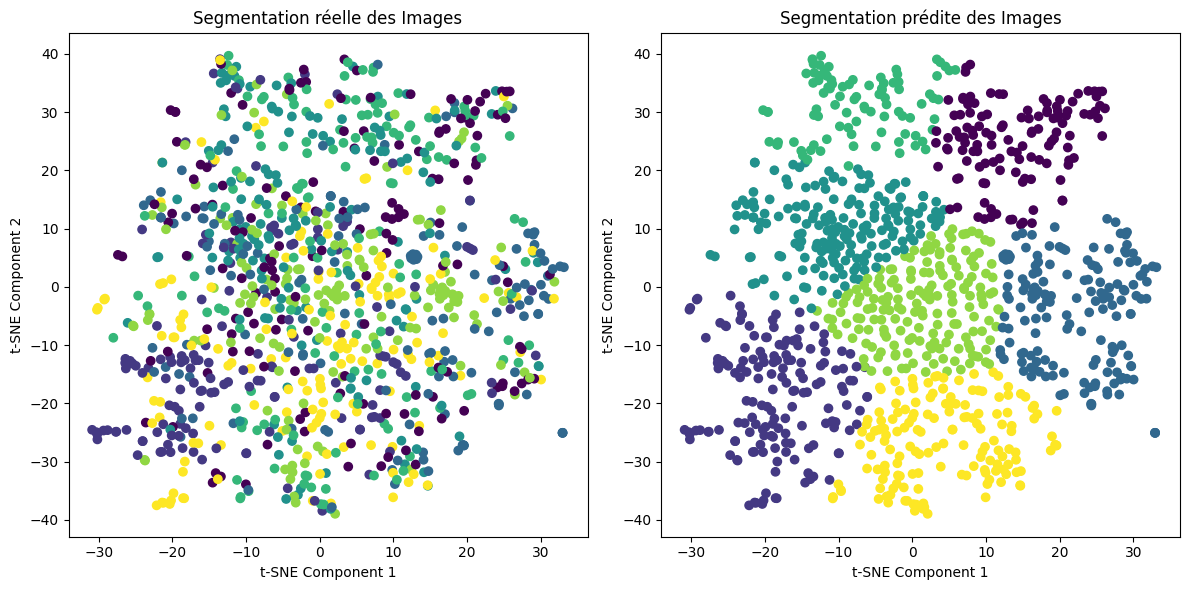

In [85]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(df_tsne['tsne1'], df_tsne['tsne2'], c=df_tsne['cluster'], cmap='viridis')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Segmentation réelle des Images')

plt.subplot(1, 2, 2)
plt.scatter(df_tsne['tsne1'], df_tsne['tsne2'], c=cls_labels_transform, cmap='viridis')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Segmentation prédite des Images')

plt.tight_layout()
plt.show()

In [86]:
from sklearn import metrics
ARI = np.round(metrics.adjusted_rand_score(df_tsne['cluster'], cls_labels_transform),4)
ARI

0.0647